In [1]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
import rpy2.robjects as robjects

In [3]:
rdata = robjects.r['load']("./pvclust.RData")

In [4]:
def hclust_to_scipy_linkage(result, labels=None):
    """Turn R hclust result obj into scipy linkage matrix format"""
    # in hclust merge matrix, negative value is for singleton
    raw_linkage = pd.DataFrame(np.array(result[0]))
    nobs = raw_linkage.shape[0] + 1
    raw_linkage[2] = np.array(result[1])
    raw_linkage.index = raw_linkage.index + nobs

    # in hclust merge matrix, positive value is for non-singleton
    scipy_linkage = raw_linkage.copy()
    scipy_linkage[raw_linkage.iloc[:, :2] < 0] += nobs
    scipy_linkage[raw_linkage.iloc[:, :2] > 0] += (nobs - 1)
    total_obs = nobs

    # add the 4th col: number of singleton
    cluster_dict = {}
    if labels is None:
        labels = list(range(total_obs))
    for cur_cluster_id, (left, right, distance) in scipy_linkage.iterrows():
        left = int(left)
        right = int(right)
        cluster_dict[cur_cluster_id] = {'left': set(), 'right': set()}
        if (left < total_obs) and (right < total_obs):
            left = labels[left]
            right = labels[right]
            # merge of 2 original observations
            cluster_dict[cur_cluster_id]['left'].add(left)
            cluster_dict[cur_cluster_id]['right'].add(right)
        else:
            # left and/or right are cluster
            if left < total_obs:
                left = labels[left]
                cluster_dict[cur_cluster_id]['left'].add(left)
            else:
                # node are cluster
                cluster_dict[cur_cluster_id]['left'].update(
                    cluster_dict[left]['left'])
                cluster_dict[cur_cluster_id]['left'].update(
                    cluster_dict[left]['right'])
            if right < total_obs:
                right = labels[right]
                cluster_dict[cur_cluster_id]['right'].add(right)
            else:
                # node are cluster
                cluster_dict[cur_cluster_id]['right'].update(
                    cluster_dict[right]['left'])
                cluster_dict[cur_cluster_id]['right'].update(
                    cluster_dict[right]['right'])
        cur_cluster_id += 1

    cluster_records = {}
    for cluster, _sub_dict in cluster_dict.items():
        total_n = len(_sub_dict['left']) + len(_sub_dict['right'])
        cluster_records[cluster] = total_n
    scipy_linkage[3] = pd.Series(cluster_records)
    
    # dendrogram
    orders = list(result[2])
    labels = list(result[3])

    # correct order of the final dendrogram
    r_order = [labels[i-1] for i in orders]

    dendro = dendrogram(scipy_linkage, no_plot=True)
    python_order = pd.Series({a:b for a, b in zip(dendro['leaves'], r_order)}).sort_index().tolist()

    dendro = dendrogram(scipy_linkage, labels=python_order, no_plot=True)
    return scipy_linkage, python_order, dendro

In [5]:
exc_data = robjects.r['exc_result']
inh_data = robjects.r['inh_result']

In [6]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cluster_map = {c.replace(' ', '.').replace('-', '.'):c for c in cell_tidy_data['SubType'].unique()}

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


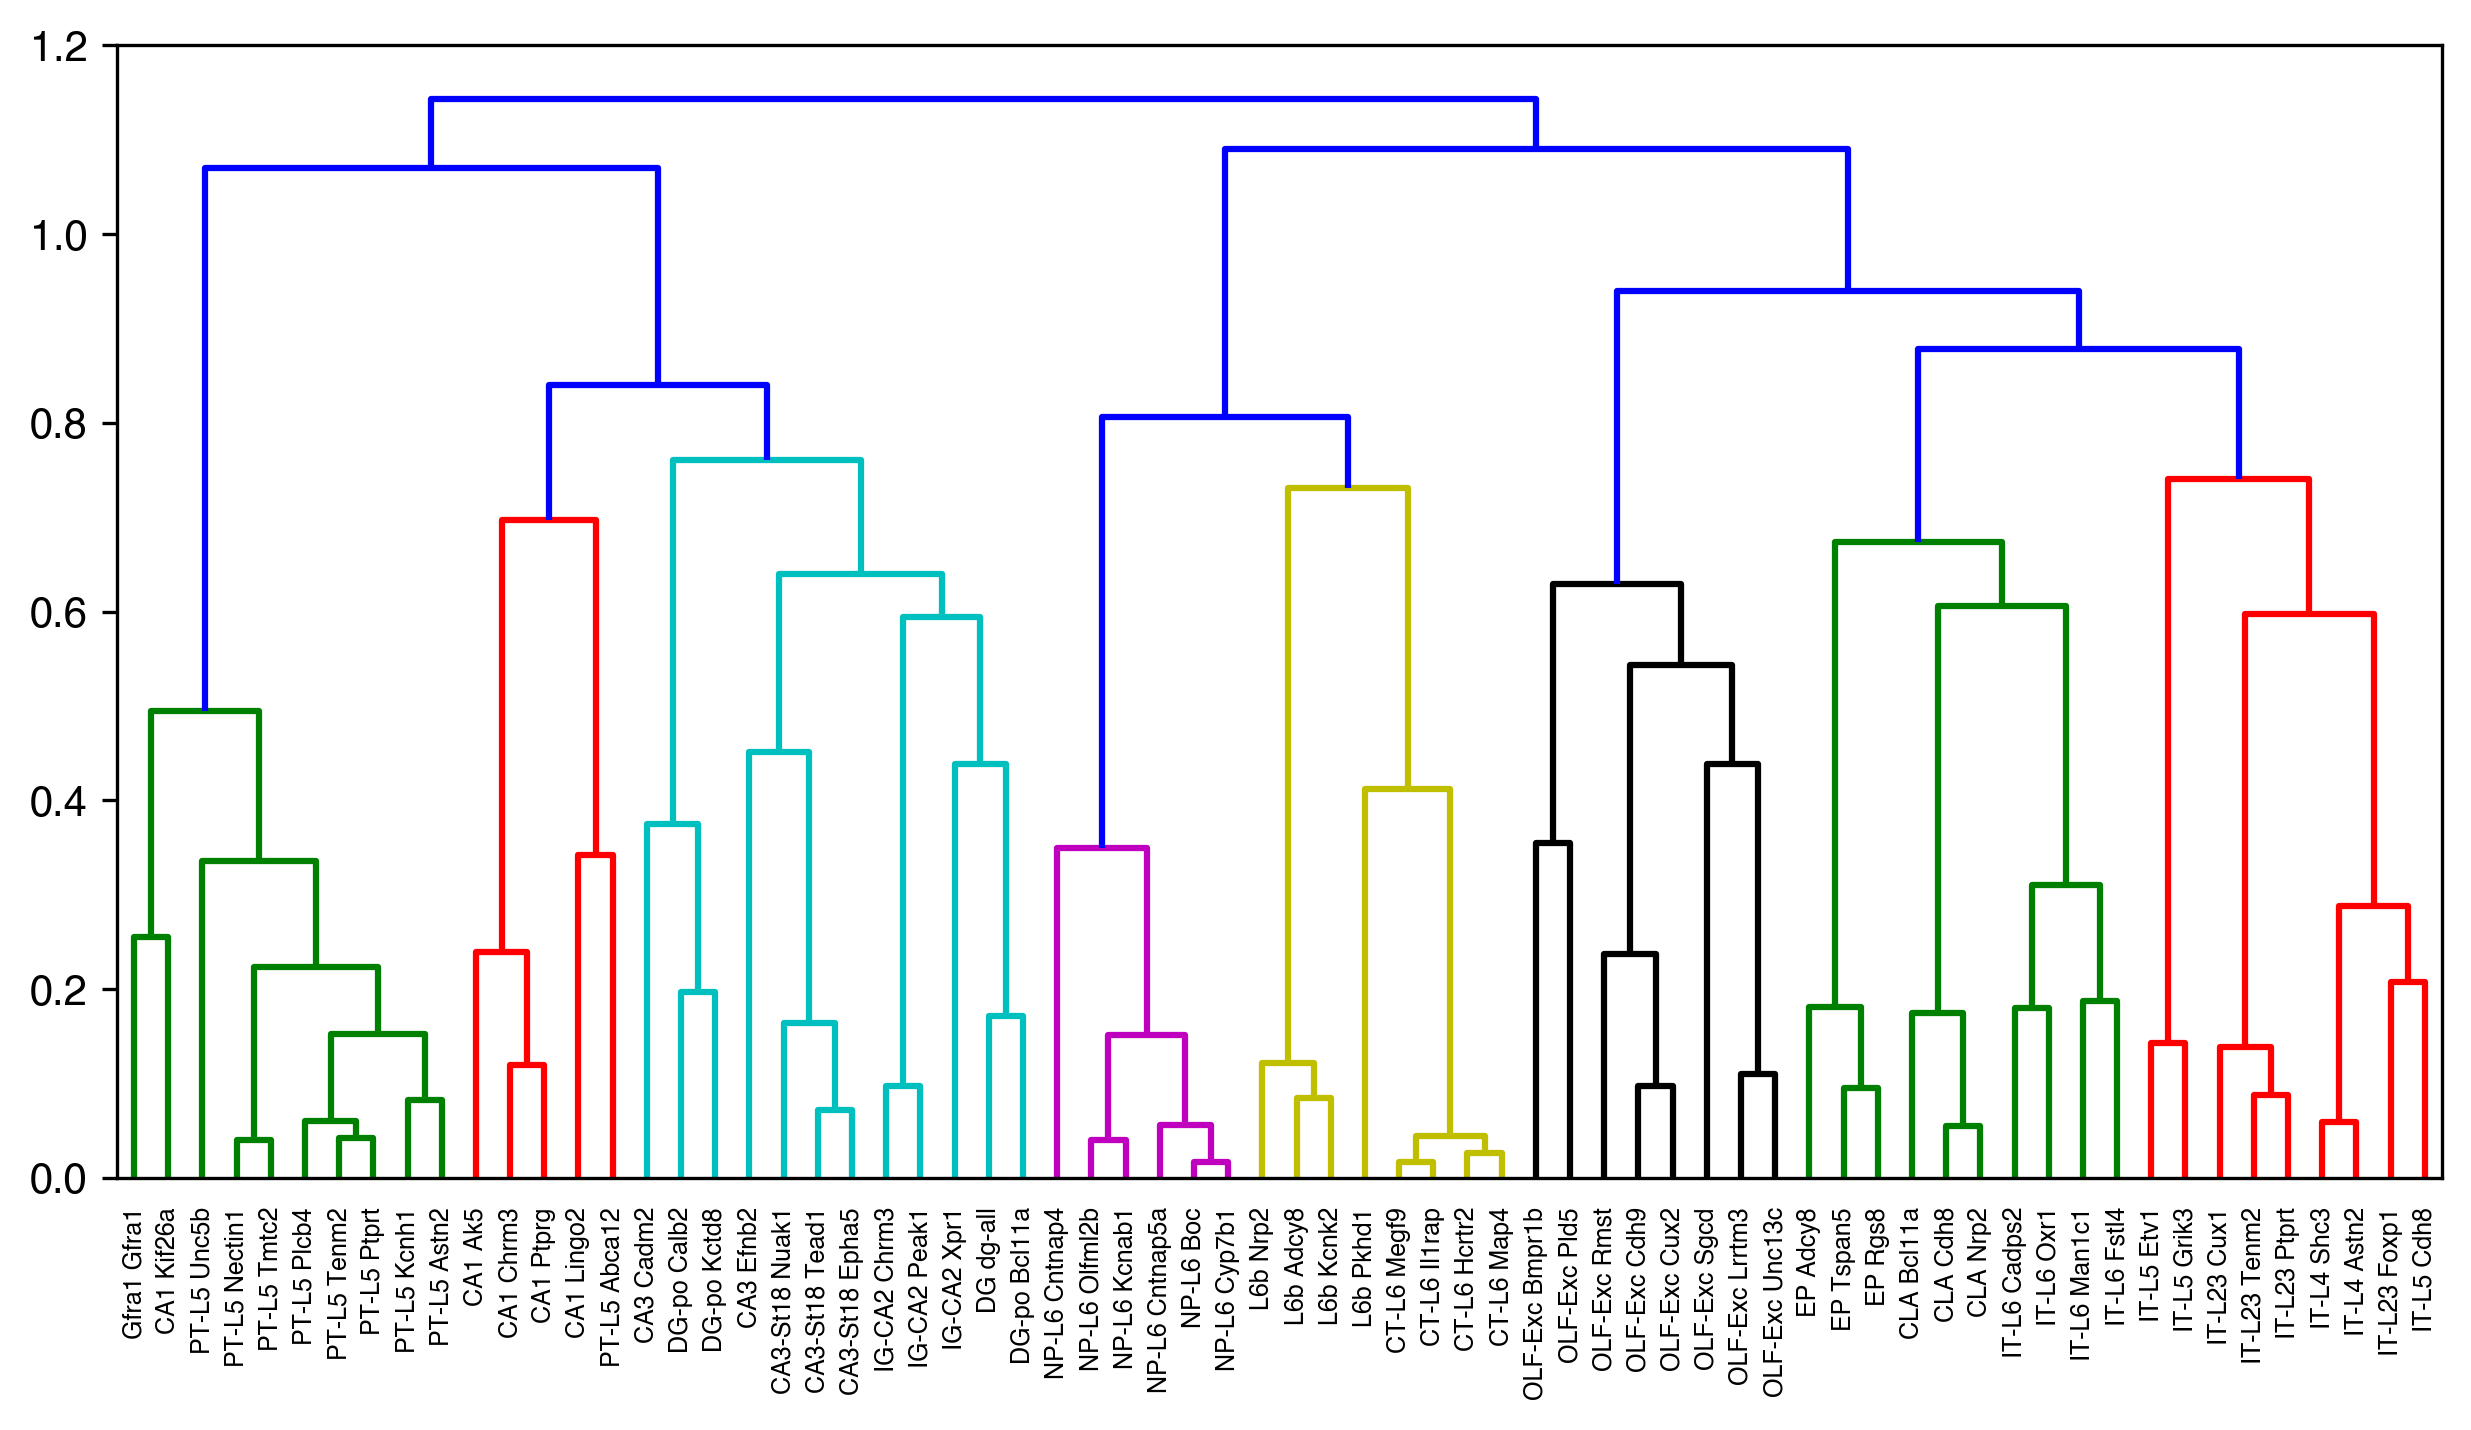

In [7]:
scipy_linkage, labels, dendro = hclust_to_scipy_linkage(exc_data[0], labels=None)
labels = [cluster_map[l] for l in labels]

scipy_linkage.to_csv('Exc.linkage.csv')
with open('Exc.linkage.orders.txt', 'w') as f:
    f.write('\n'.join(labels))
joblib.dump(dendro, 'Exc.dendrogram.lib')

plt.figure(figsize=(10, 5), dpi=300)
dendrogram(scipy_linkage, labels=labels)

from ALLCools.dmr.dendrogram import extract_all_nodes
non_singleton_node_dict = extract_all_nodes(scipy_linkage, labels=labels)
joblib.dump(non_singleton_node_dict, 'Exc.non_singleton_node_dict.lib')
pass

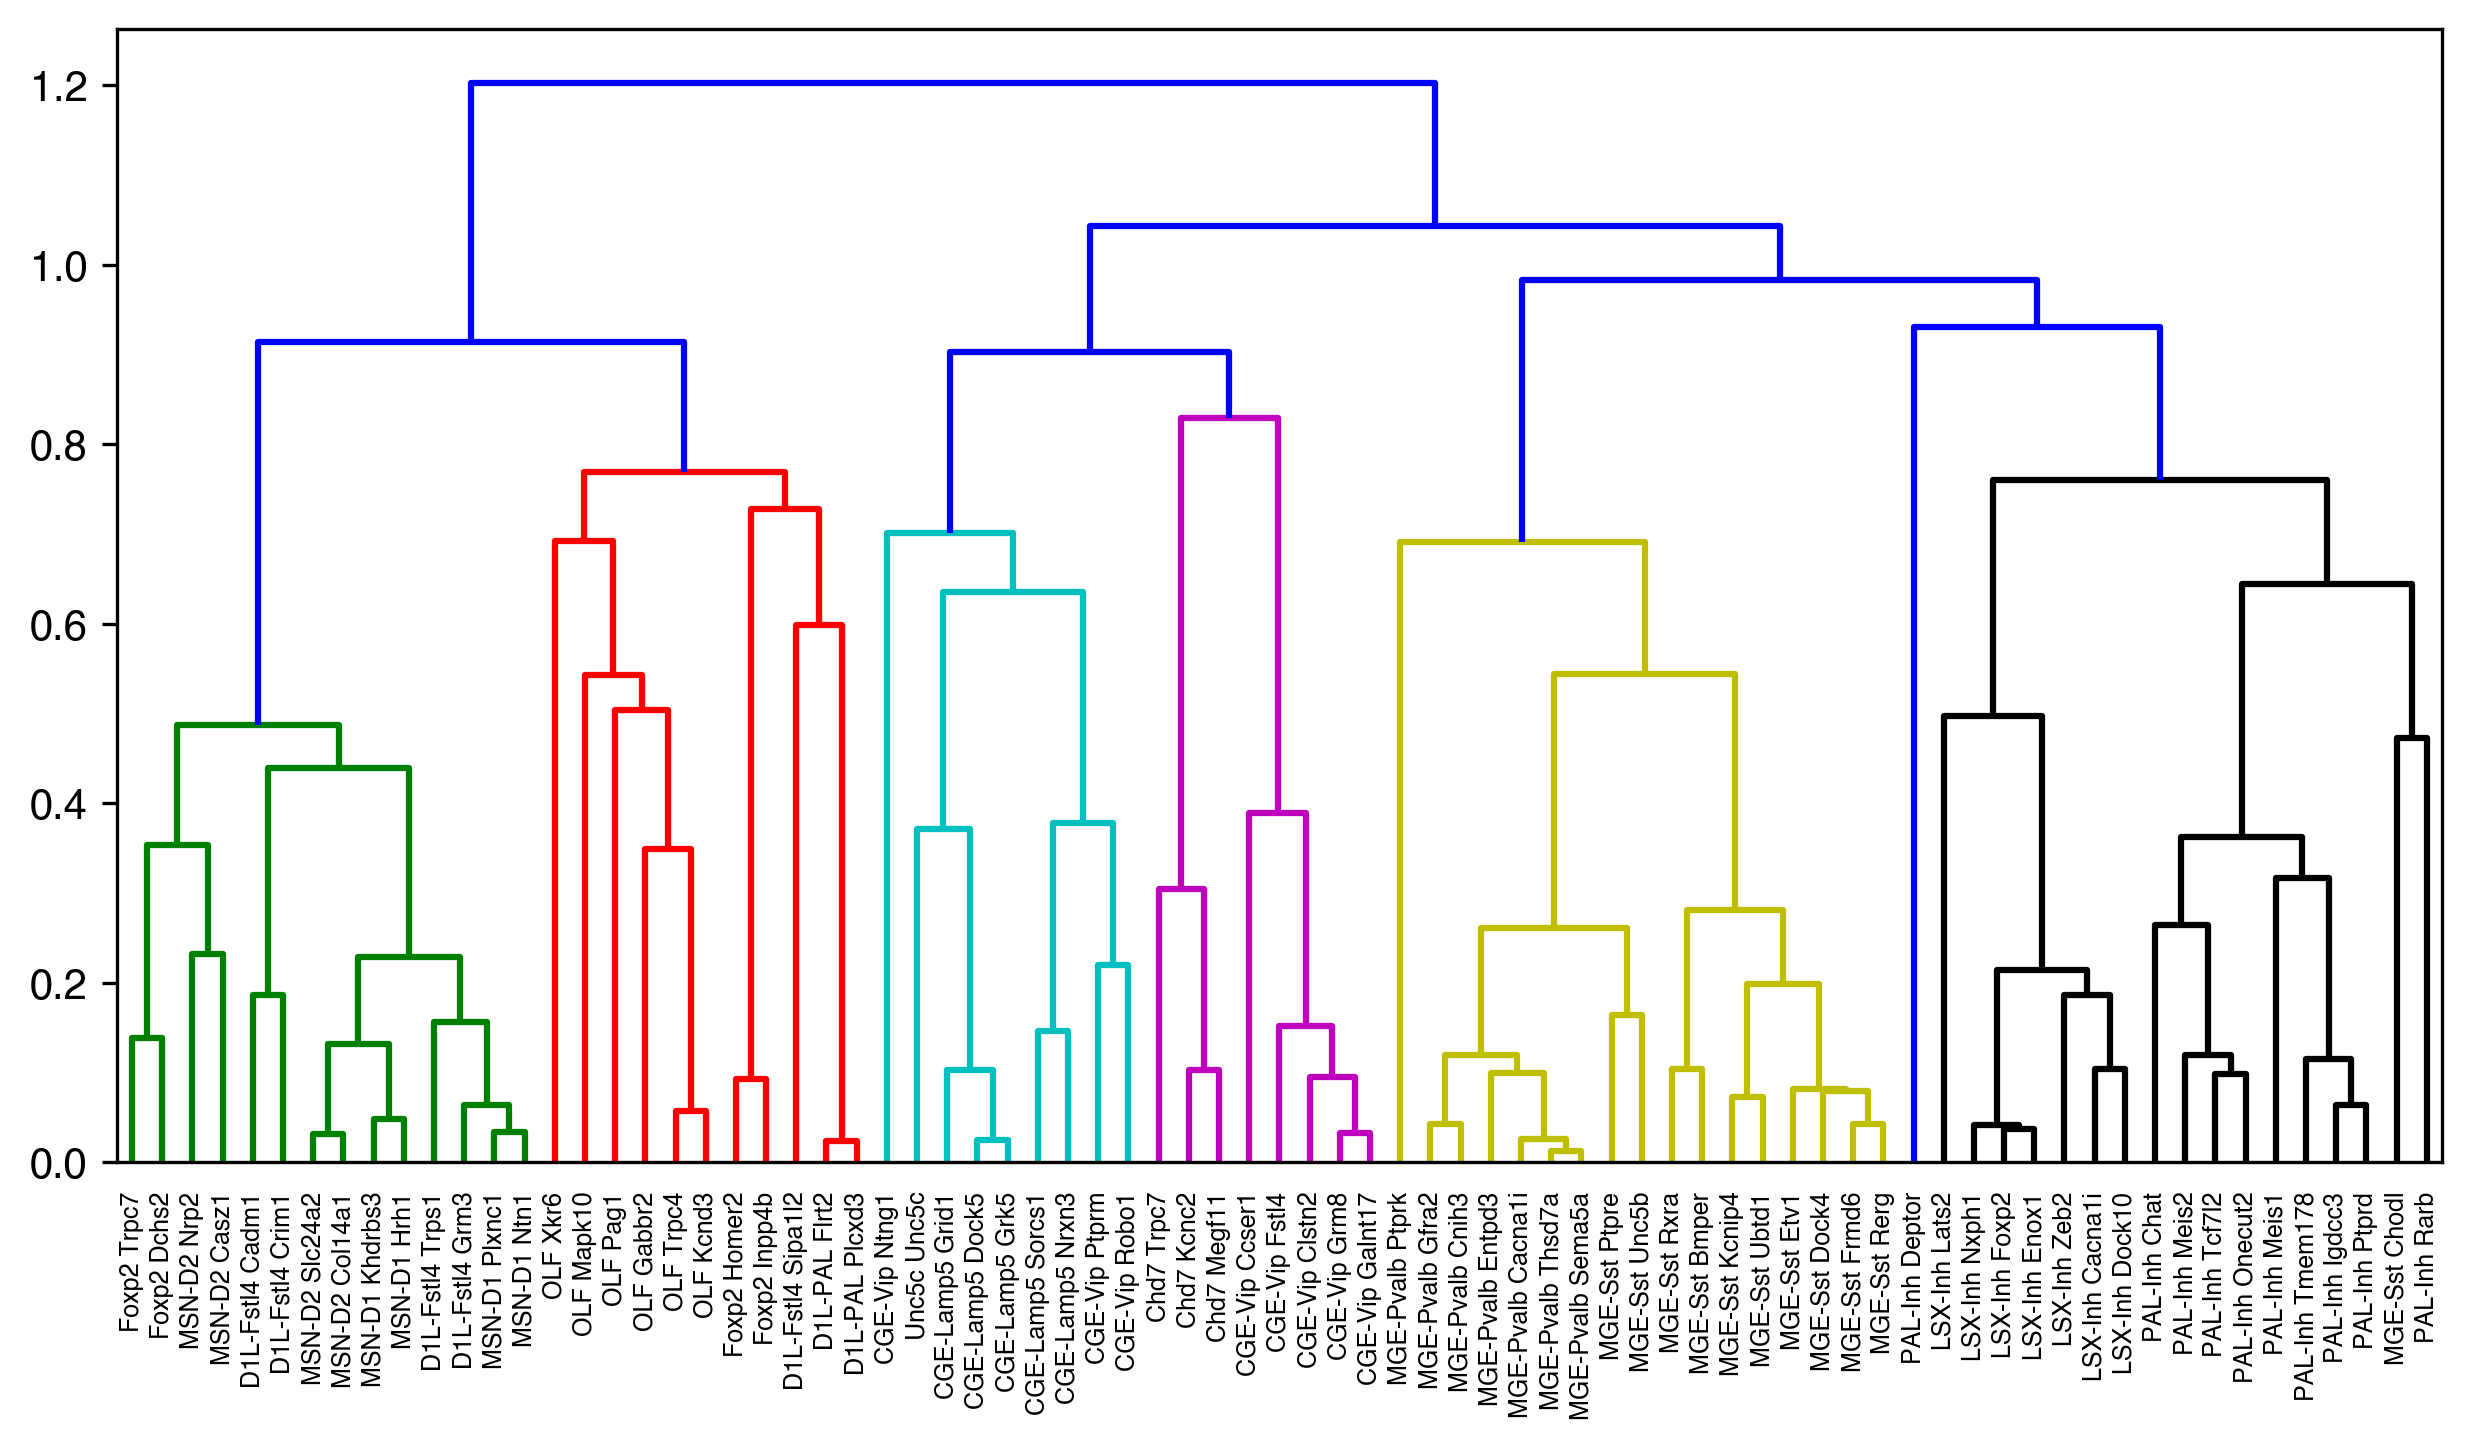

In [8]:
scipy_linkage, labels, dendro = hclust_to_scipy_linkage(inh_data[0], labels=None)
labels = [cluster_map[l] for l in labels]

scipy_linkage.to_csv('Inh.linkage.csv')
with open('Inh.linkage.orders.txt', 'w') as f:
    f.write('\n'.join(labels))
joblib.dump(dendro, 'Inh.dendrogram.lib')

plt.figure(figsize=(10, 5), dpi=300)
dendrogram(scipy_linkage, labels=labels)

from ALLCools.dmr.dendrogram import extract_all_nodes
non_singleton_node_dict = extract_all_nodes(scipy_linkage, labels=labels)
joblib.dump(non_singleton_node_dict, 'Inh.non_singleton_node_dict.lib')
pass

In [14]:
from ALLCools.dmr.dmr_lineage_plot import *

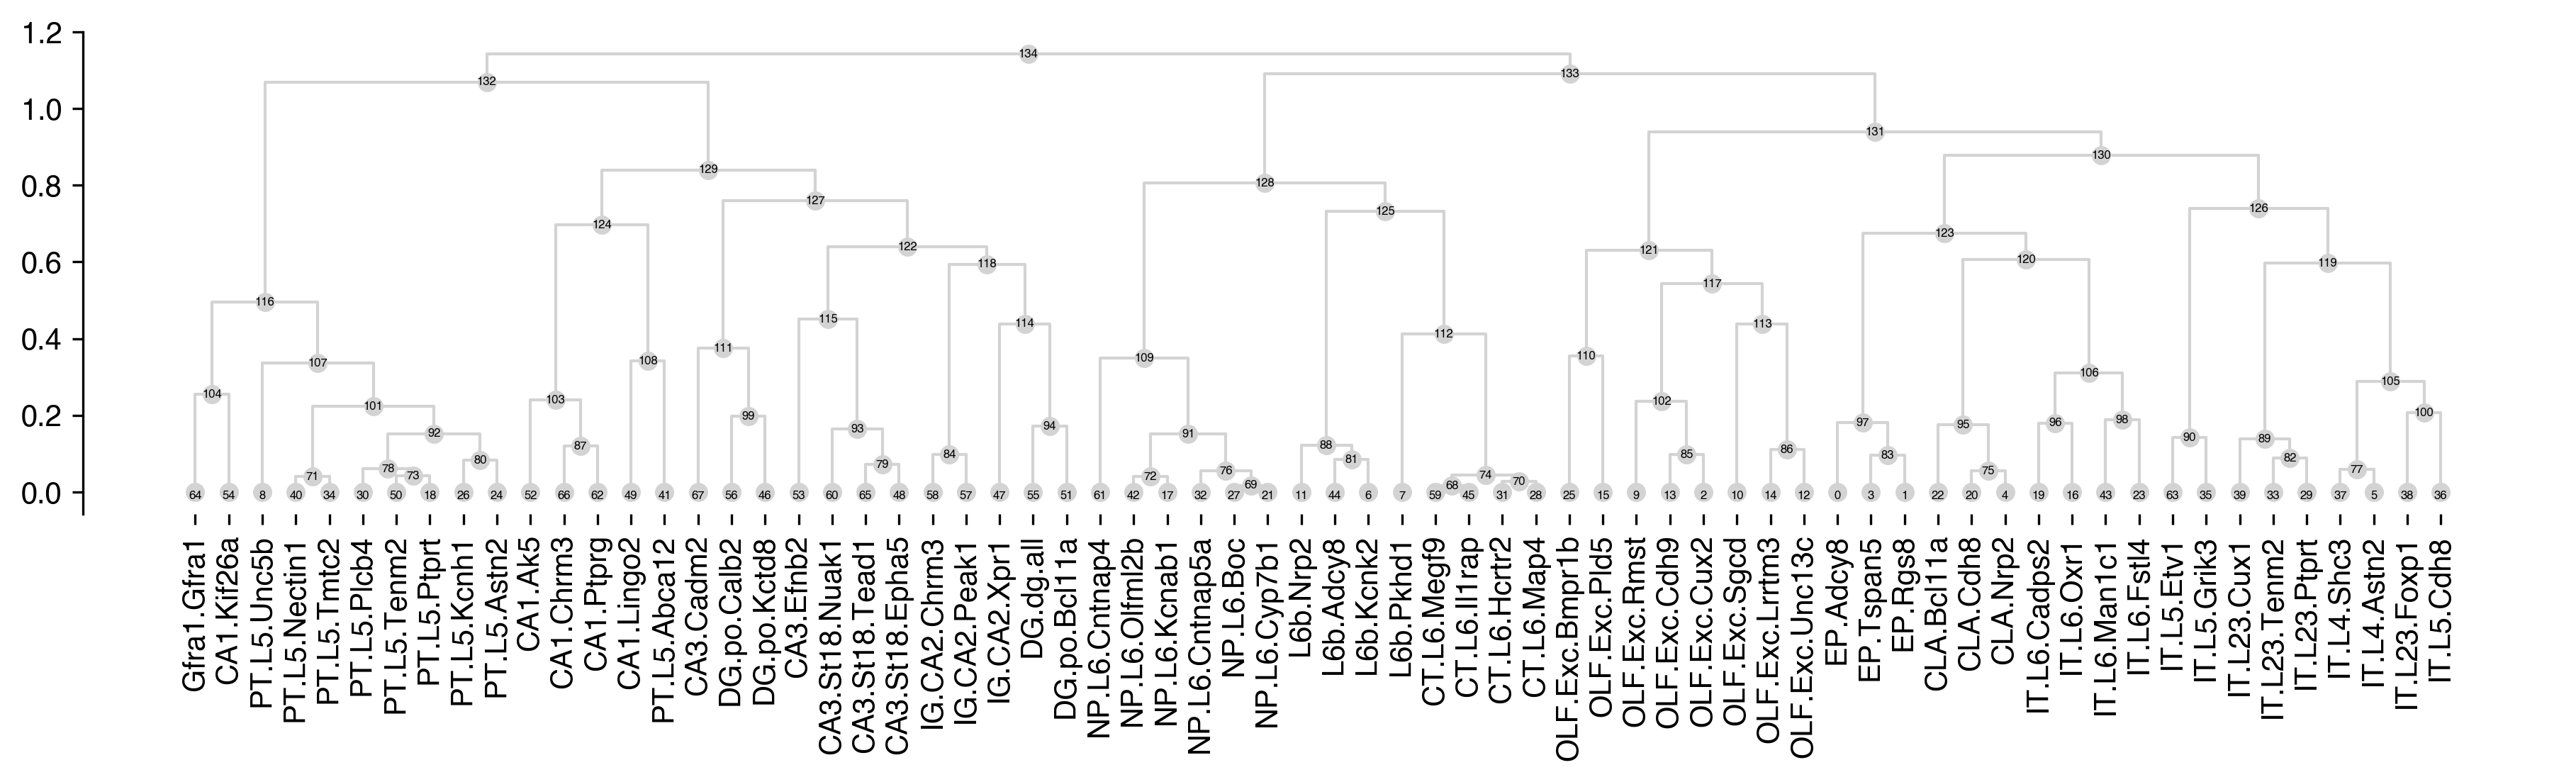

In [45]:
scipy_linkage, labels, dendro = hclust_to_scipy_linkage(exc_data[0], labels=None)
scipy_linkage.reset_index(drop=True, inplace=True)


fig, ax = plt.subplots(figsize=(15, 3), dpi=300)

plot_dendrogram(scipy_linkage,
                list(labels),
                dendro_kws=None,
                ax=ax,
                branch_type='straight',
                plot_node_id=True,
                plot_kws=None,
                node_hue=None,
                node_hue_norm=None,
                palette='viridis',
                node_size=None,
                node_size_norm=None,
                line_hue=None,
                line_hue_norm=None,
                sizes=None,
                size=30,
                linewidth=1,
                color=None)
sns.despine(ax=ax, left=False, bottom=True)
ax.set(xticks=range(0, len(dendro['ivl'])), xticklabels=dendro['ivl'])
ax.xaxis.set_tick_params(rotation=90)
pass

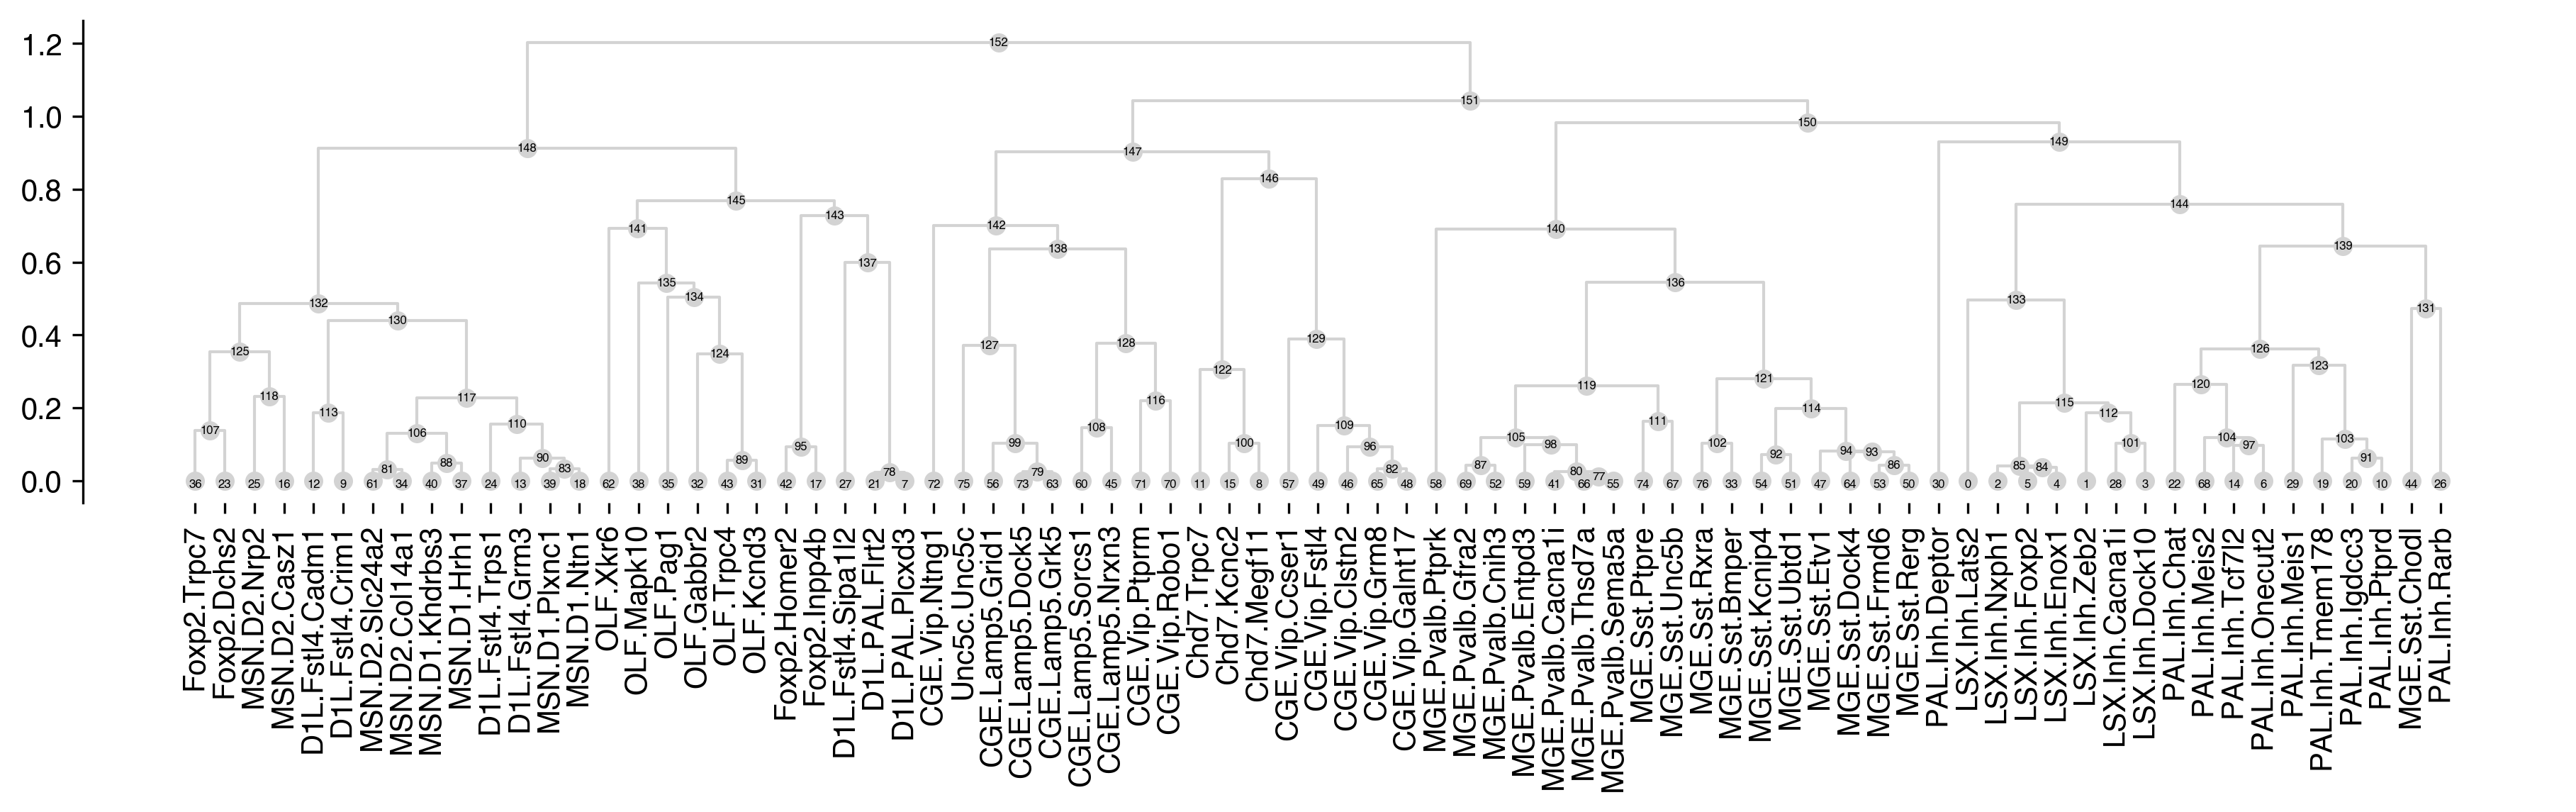

In [46]:
scipy_linkage, labels, dendro = hclust_to_scipy_linkage(inh_data[0], labels=None)
scipy_linkage.reset_index(drop=True, inplace=True)


fig, ax = plt.subplots(figsize=(15, 3), dpi=300)

plot_dendrogram(scipy_linkage,
                list(labels),
                dendro_kws=None,
                ax=ax,
                branch_type='straight',
                plot_node_id=True,
                plot_kws=None,
                node_hue=None,
                node_hue_norm=None,
                palette='viridis',
                node_size=None,
                node_size_norm=None,
                line_hue=None,
                line_hue_norm=None,
                sizes=None,
                size=30,
                linewidth=1,
                color=None)
sns.despine(ax=ax, left=False, bottom=True)
ax.set(xticks=range(0, len(dendro['ivl'])), xticklabels=dendro['ivl'])
ax.xaxis.set_tick_params(rotation=90)
pass